In [1]:
%matplotlib inline

from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pipeline = load('pipeline.joblib')
history = pd.read_csv('lending-club.csv')
X = history.drop(columns='Interest Rate')
y_pred_log = pipeline.predict(X)
y_pred = np.expm1(y_pred_log)

[01:08:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [104]:
from tqdm import tnrange

def partial_dependence(estimator, X, feature, percentiles=(5, 95), grid_resolution=100):
    X = X.copy()
    
    start_percentile, stop_percentile = percentiles
    grid = np.linspace(start=np.percentile(X[feature], start_percentile), 
                       stop=np.percentile(X[feature], stop_percentile), 
                       num=grid_resolution)
    
    y_pred = np.empty(grid_resolution)
    for i in tnrange(grid_resolution):
        X[feature] = grid[i]
        y_pred[i] = np.average(estimator.predict(X))
    
    return grid, y_pred

In [105]:
encoder = pipeline.named_steps['onehotencoder']
model = pipeline.named_steps['xgbregressor']

In [106]:
X_encoded = encoder.transform(X)

In [114]:
feature = 'Annual Income'
grid, y_pred_log = partial_dependence(model, X_encoded, feature)
y_pred = np.expm1(y_pred_log)

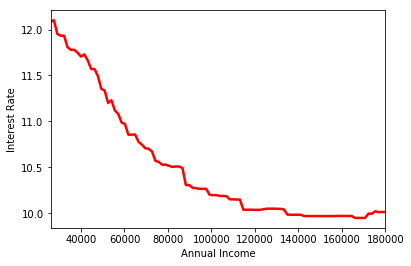

In [117]:
y = history['Interest Rate']
plt.plot(grid, y_pred, '-', color='red', linewidth=2.5)
# plt.plot(X, y, 'o', color='grey', alpha=0.01)
plt.xlim(min(grid), max(grid))
plt.xlabel(feature)
plt.ylabel(y.name)
plt.show()

In [128]:
from tqdm import tnrange

def partial_dependence_interact(estimator, X, feature1, feature2, percentiles=(5, 95), grid_resolution=100):
    X = X.copy()
    
    start_percentile, stop_percentile = percentiles
    x = np.linspace(start=np.percentile(X[feature1], start_percentile), 
                    stop=np.percentile(X[feature1], stop_percentile), 
                    num=grid_resolution)
    
    y = np.linspace(start=np.percentile(X[feature2], start_percentile), 
                    stop=np.percentile(X[feature2], stop_percentile), 
                    num=grid_resolution)
    
    z = np.empty((grid_resolution, grid_resolution))
    for i in tnrange(grid_resolution):
        for j in tnrange(grid_resolution):
            X[feature1] = x[i]
            X[feature2] = y[j]
            z[i, j] = np.average(estimator.predict(X))
    
    return x, y, z

In [129]:
x, y, z = partial_dependence_interact(model, X_encoded, 'Annual Income', 'Credit Score')

KeyboardInterrupt: 